# Set up

In [3]:
import warnings
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import re
import copy
import numpy as np
import pandas as pd
import sklearn
from sklearn.impute import SimpleImputer
from scipy.stats import pearsonr, spearmanr
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [4]:
warnings.filterwarnings('ignore')

In [5]:
pio.templates.default = "plotly_dark"

# Importing datasets

The **training dataset** (train.csv) contains the data we will fit the model with. 

We will then make predictions using the data in the **testing dataset** (test.csv). 

The **data description file** (data_description.txt) contains information about each feature. For numerical features it provides a description of the feature, but for categorical features it provides a description as well as the possible values the feature contains.

In [17]:
class DataImporter:
  """
  Imports the training dataset, test dataset and the description file.
  Fixes minor dataset errors and converts description file into a dictionary.
  """

  def __init__(self, train, test, desc):
    self.train_path = train
    self.test_path = test
    self.desc_path = desc
    self.__df_train = None
    self.__df_test = None
    self.__fields = None

  def __convert_desc_into_list(self):
    """
    Extracts the features and their descriptions from the description file and converts them a dictionary of [feature]:[description] pairs
    """
    with open(self.desc_path, "r") as desc_txt:
      desc = desc_txt.read()

    regex = re.compile(r"\b(.+):(.*)\n")
    fields = dict(re.findall(regex, desc))
    return fields

  def __import_data(self):
    """
    Imports the datasets and fields
    """
    self.__df_train = pd.read_csv(self.train_path)
    self.__df_test = pd.read_csv(self.test_path)
    self.__fields = self.__convert_desc_into_list()
    return self

  def __fix_datasets(self):
    """
    Fixes a column naming error in the datasets
    """
    self.__df_train.rename(columns={"KitchenAbvGr": "Kitchen", "BedroomAbvGr": "Bedroom"}, inplace=True)
    self.__df_test.rename(columns={"KitchenAbvGr": "Kitchen", "BedroomAbvGr": "Bedroom"}, inplace=True)
    return self

  def get_data(self):
    """
    Imports the data, applies minor fixes and returns it (training dataset, testing dataset, fields)
    """
    self.__import_data()
    self.__fix_datasets()
    return self.__df_train, self.__df_test, self.__fields

Let's import all of our data.

In [32]:
TRAIN_CSV = "train.csv"
TEST_CSV =  "test.csv"
DESC_TXT = "data_description.txt"

data_importer = DataImporter(TRAIN_CSV, TEST_CSV, DESC_TXT)

df_train, df_test, fields = data_importer.get_data()

df_train.shape, df_test.shape

((1460, 81), (1459, 80))

Let's take a quick look at each of them.

In [19]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [20]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [21]:
fields

{'MSSubClass': ' Identifies the type of dwelling involved in the sale.\t',
 'MSZoning': ' Identifies the general zoning classification of the sale.',
 'LotFrontage': ' Linear feet of street connected to property',
 'LotArea': ' Lot size in square feet',
 'Street': ' Type of road access to property',
 'Alley': ' Type of alley access to property',
 'LotShape': ' General shape of property',
 'LandContour': ' Flatness of the property',
 'Utilities': ' Type of utilities available',
 'LotConfig': ' Lot configuration',
 'LandSlope': ' Slope of property',
 'Neighborhood': ' Physical locations within Ames city limits',
 'Condition1': ' Proximity to various conditions',
 'Condition2': ' Proximity to various conditions (if more than one is present)',
 'BldgType': ' Type of dwelling',
 'HouseStyle': ' Style of dwelling',
 '1.5Fin\tOne and one-half story': ' 2nd level finished',
 '1.5Unf\tOne and one-half story': ' 2nd level unfinished',
 '2.5Fin\tTwo and one-half story': ' 2nd level finished',
 '2

# Cleaning datasets

In [30]:
class DatasetCleaner():

  def __init__(self):
    self.df = None

  def clean(self, df, df_type, drop_cols=[], outlier_cols=[]):
    """
    Cleans the dataset. This includes dropping columns, imputing null values, fixing data types and removing outliers.
    Outlier removal will not be done for the test dataset.
    """
    self.df = df
    if df_type=="train":
      self.__drop_cols(drop_cols)
      self.__impute_null()
      self.__fix_data_types()
      self.__remove_outliers(outlier_cols)
    if df_type=="test":
      self.__drop_cols(drop_cols)
      self.__impute_null()
      self.__fix_data_types()
    return self.df

  def __drop_cols(self, cols):
    """
    Drops columns in df
    """
    self.df.drop(columns=cols, inplace=True)
    return self

  def __get_upper_fence(self, col):
    """
    Returns the upper fence of df[col].
    Calculated as Q3 + (1.5 * IQR)
    """
    stats = self.df[col].describe()
    Q1 = stats["25%"]
    Q3 = stats["75%"]
    IQR = Q3 - Q1
    return Q3 + (1.5 * IQR)

  def __impute_null(self):
    """
    Aggregate function which imputes all null values.
    """
    self.__impute_zeroes(["LotFrontage", "MasVnrArea", "BsmtFinSF1", "GarageYrBlt"])
    self.__impute_absences(["Alley", "MasVnrType", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", 
    "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish",
    "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature",
    "Electrical"])
    self.__impute_average(["BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath",
    "GarageCars", "GarageArea"])
    self.__impute_with_popular(["MSZoning", "Utilities", "Exterior1st", "Exterior2nd", "KitchenQual",
    "Functional", "SaleType"])
    return self

  def __impute_zeroes(self, cols):
    """
    Imputes nan values with 0
    """
    imputer = SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=0)
    self.df[cols] = imputer.fit_transform(self.df[cols])
    return self

  def __impute_absences(self, cols):
    """
    Imputes nan and "None" values with "Absent"
    """
    imputer = SimpleImputer(missing_values=np.nan, strategy="constant", fill_value="Absent")
    self.df[cols] = imputer.fit_transform(self.df[cols])
    imputer = SimpleImputer(missing_values="None", strategy="constant", fill_value="Absent")
    self.df[cols] = imputer.fit_transform(self.df[cols])
    return self

  def __impute_average(self, cols):
    """
    Imputes nan values with the mean
    """
    imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
    self.df[cols] = imputer.fit_transform(self.df[cols])
    return self

  def __impute_with_popular(self, cols):
    """
    Imputes nan values with most popular value in the column
    """
    for col in cols:
      vc = self.df[col].value_counts()
      fill_value = vc.index[0]
      self.df[col].fillna(fill_value, inplace=True)
    return self

  def __fix_data_types(self):
    """
    Fixes data types of certain columns.
    Specifically, converts BsmtFinsSF1 and GarageYrBlt from object to int and converts MSSubClass from int to string.
    """
    cols = ["BsmtFinSF1", "GarageYrBlt"]
    for col in cols:
      self.df[col] = self.df[col].astype(np.int)
    self.df["MSSubClass"] = self.df["MSSubClass"].apply(lambda x: str(x))
    return self

  def __remove_outliers(self, cols):
    for col in cols:
      self.df = self.df[self.df[col] < self.__get_upper_fence(col)]
    return self

Let's clean our datasets! This involves imputing null values, removing outliers (for training dataset), fixing data types and dropping unnecessary columns.

In [33]:
data_cleaner = DatasetCleaner()

df_train = data_cleaner.clean(
    df=df_train, 
    df_type="train", 
    drop_cols=["Id"], 
    outlier_cols=["LotFrontage"]
)

df_test = data_cleaner.clean(
    df=df_test,
    df_type="test"
)

In [34]:
df_train.shape, df_test.shape

((1444, 80), (1459, 80))

We will need the Id column of the testing dataset later for prediction purposes.

In [35]:
test_id = df_test.pop("Id")

In [36]:
df_train.shape, df_test.shape

((1444, 80), (1459, 79))

# EDA

Exploratory Data Analysis. In this section we will be:
- Analysing the feature distributions
- Analysing the correlation of each feature to SalePrice to understand which features are good predictors of the target variable
- Analysing the correlations between features, so we have an idea of which features we can drop

## Feature Distributions Overview

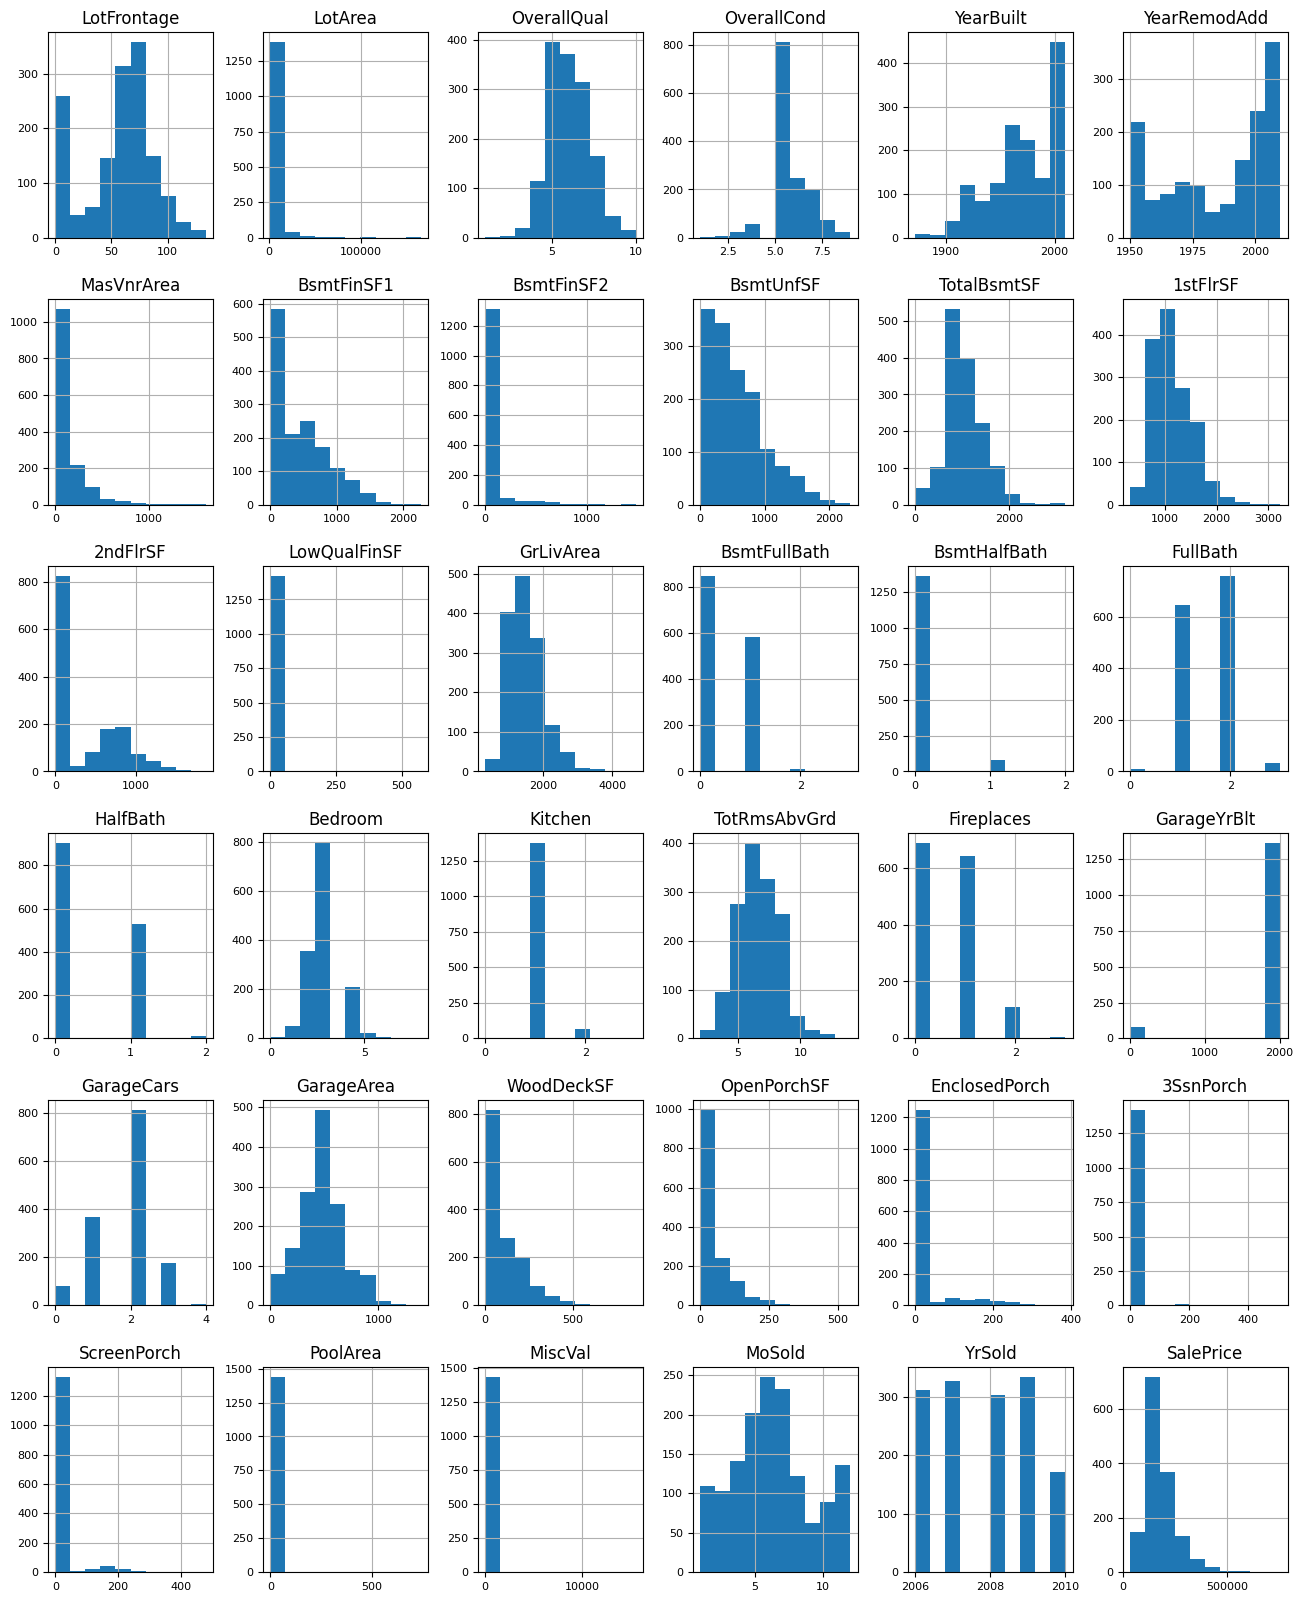

In [37]:
df_train.hist(figsize=(16, 20), xlabelsize=8, ylabelsize=8)
plt.show()

## Feature Correlation to SalePrice

Let's plot a bar graph of the correlation of all the numerical columns to SalePrice. This will allow us to see the features that are good predictors of the target variable.

In [38]:
salesprice_corr = df_train.corr()["SalePrice"].sort_values(ascending=False)
fig = px.bar(
    x=salesprice_corr.index,
    y=salesprice_corr.values,
    color=salesprice_corr.values,
    title="Correlation to SalePrice",
    labels={
        "x": "Features",
        "y": "Pearson Correlation to SalePrice"
    },
)
fig.update_layout(coloraxis_showscale=False)

From this graph, we can see that these features are highly correlated to SalePrice:
- **OverallQual** (Rates the overall material and finish of the house)
- **GrLivArea** (Above grade (ground) living area square feet)
- **TotalBsmtSF** (Total square feet of basement area)
- **GarageCars** (Size of garage in car capacity)
- **GarageArea** (Size of garage in square feet)
- **1stFlrSF** (First Floor square feet)
- **FullBath** (Full bathrooms above grade)

Let's graph scatter plots for these features based on their relationship to SalePrice:

In [39]:
def plot_scatter(df, x, y, color=None):
  sct = px.scatter(
      df,
      x=x,
      y=y,
      trendline="ols",
      title=f"{y} by {x} ({fields[x]})" if y=="SalePrice" else f"{y} ({fields[y]}) by {x} ({fields[x]})",
      color_discrete_sequence=[color]
  )
  sct.show()

In [40]:
plot_scatter(df_train, "OverallQual", "SalePrice", "#01befe")

In [41]:
plot_scatter(df_train, "GrLivArea", "SalePrice", "#ffdd00")

In [42]:
plot_scatter(df_train, "TotalBsmtSF", "SalePrice", "#ff7d00")

In [43]:
plot_scatter(df_train, "TotalBsmtSF", "SalePrice", "#ff006d")

In [44]:
plot_scatter(df_train, "TotalBsmtSF", "SalePrice", "#adff02")

## Correlations between features

Let's analyse the correlations between the features of the dataset. This will allow us to see which features we can possibly drop, because there is no point in having two features that are highly correlated with each other.

In [45]:
def get_top_n_correlated_features(df, n, method="pearson", reverse=False):
  """
  Returns the top n pairs of correlated features in df
  """
  # get correlations between all variables
  corrs = []
  for key1, arr in df.corr(method=method).iteritems():
    for key2, corr in arr.iteritems():
      corrs.append((key1, key2, corr))
  # sort by absolute value of correlation
  corrs.sort(key=lambda x: abs(x[2]), reverse=True)
  # remove every second correlation as they are duplicates
  corrs = corrs[::2]
  # remove elements that are correlated to themselves (corr=1)
  corrs = list(filter(lambda x: x[2] != 1.0, corrs))
  # remove correlations to target variable
  corrs = list(filter(lambda x: "SalePrice" not in x, corrs))
  # if reverse=True, return the bottom n correlations
  if reverse:
    return corrs[-n:]
  # if reverse=False, return the top n correlations
  return corrs[:n]

Let's get the top 5 pairs of correlated features.

In [46]:
corrs = get_top_n_correlated_features(df_train, 5)
corrs

[('GarageCars', 'GarageArea', 0.8872800030143396),
 ('GrLivArea', 'TotRmsAbvGrd', 0.8300495814716549),
 ('TotalBsmtSF', '1stFlrSF', 0.809095354330281),
 ('2ndFlrSF', 'GrLivArea', 0.6913795268804347),
 ('Bedroom', 'TotRmsAbvGrd', 0.6793809153562698)]

Let's plot each of these correlations on a scatter plot.

In [47]:
colors = ["#04e762", "#f5b700", "#dc0073", "#008bf8", "#89fc00"]
for i in range(5):
  corr = corrs[i]
  plot_scatter(df_train, corr[0], corr[1], colors[i])

# Feature engineering/selection

Feature engineering is the process of extracting new features or modifying existing ones.

Feature selection is the process of picking the best features from the dataset.

In this section, we will accomplish both feature engineering and selection, and also create a complete pipeline which houses all this functionality.

## In-depth feature engineering/selection

Let's perform detailed feature engineering on the datasets. If you want to see the reasoning behind the methods performed in this section, check out House Prices Prediction Version 1, which is also in this repository.

In [48]:
class FeatEngHelper():
  """
  Houses all the helper functions used by the FeatureEngineering class
  """
  
  AUTO = 1

  @classmethod
  def replace_values(cls, df, col, to_be_replaced, replacement):
    """
    Replaces values 'to_be_replaced' with 'replacement' in column 'col'
    """
    if to_be_replaced == cls.AUTO:
      df.loc[df[col].isin(cls.get_replacement_values(df, col, 50)), col] = replacement
    else:
      df.loc[df[col].isin(to_be_replaced), col] = replacement
    return df

  @staticmethod
  def drop(df, cols):
    """
    Drops columns from df
    """
    return df.drop(columns=cols)

  @staticmethod
  def get_replacement_values(df, col, thresh):
    """
    For categorical column 'col', returns all the values in 'col' that
    appear less than 'thresh' times in 'col'
    """
    replace_vals = []
    vc = df[col].value_counts()
    for cat in vc.index:
      if len(df[df[col]==cat]) <= thresh:
        replace_vals.append(cat)
    return replace_vals

  @staticmethod
  def aggregate_cols(df, cols, new_col):
    """
    Aggregates (row-wise sum) columns into a single column
    """
    df[new_col] = df[cols].sum(axis=1)
    return df

  @staticmethod
  def subtact_cols(df, col1, col2, new_col):
    """
    Subtracts col2 from col1
    """
    df[new_col] = df[col1] - df[col2]
    return df

  @staticmethod
  def bin_greater_than_zero(df, col, new_col):
    """
    Bins column with the following logic:
    - If the value is greater than 0, it is binned into 1
    - If the value is 0, it is binned into 0
    """
    df[new_col] = (df[col] > 0).astype(int)
    return df

  @staticmethod
  def apply(df, col, new_col, func):
    """
    Applies a function to each value in a column
    """
    df[new_col] = df[col].apply(func)
    return df

  @staticmethod
  def conv_month_to_season(mth):
    """
    Converts a month (e.g. 1, 5, 12) into it's corresponding Northern Hemisphere season
    """
    if mth in [12, 1, 2]:
      return "Winter"
    elif mth in [3, 4, 5]:
      return "Spring"
    elif mth in [6, 7, 8]:
      return "Summer"
    elif mth in [9, 10, 11]:
      return "Autumn"

In [49]:
class FeatureEngineering(BaseEstimator, TransformerMixin):
  """
  Performs feature engineering and feature selection on the dataset
  """

  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    # General
    X = FeatEngHelper.replace_values(X, "MSSubClass", ["70", "80", "90", "190", "85", "75", "45", "180", "40", "150"], "Other")
    X = FeatEngHelper.replace_values(X, "MSZoning", ["FV", "RH", "C (all)"], "Other")
    X = FeatEngHelper.replace_values(X, "BldgType", ["Duplex", "Twnhs", "2fmCon"], "Other")
    X = FeatEngHelper.replace_values(X, "HouseStyle", ["SFoyer", "1.5Unf", "2.5Unf", "2.5Fin"], "Other")
    X = FeatEngHelper.replace_values(X, "Functional", ["Min2", "Min1", "Mod", "Maj1", "Maj2", "Sev"], "Damaged")
    X = FeatEngHelper.drop(X, "MiscFeature")
    X = FeatEngHelper.drop(X, "MiscVal")
    X = FeatEngHelper.replace_values(X, "SaleType", ["WD", "CWD", "VWD"], "Warranty Deed")
    X = FeatEngHelper.replace_values(X, "SaleType", ["Con", "ConLw", "ConLI", "ConLD"], "Contract")
    X = FeatEngHelper.replace_values(X, "SaleType", ["COD", "Oth"], "Other")
    X = FeatEngHelper.replace_values(X, "SaleCondition", ["Abnorml", "Family", "Alloca", "AdjLand"], "Other")
    # Property Surroundings/Environment
    X = FeatEngHelper.drop(X, "Street")
    X = FeatEngHelper.replace_values(X, "Alley", ["Grvl", "Pave"], "Has Access")
    X = FeatEngHelper.drop(X, "Neighborhood")
    X = FeatEngHelper.replace_values(X, "Condition1", FeatEngHelper.AUTO, "Other")
    X = FeatEngHelper.drop(X, "Condition2")
    X = FeatEngHelper.replace_values(X, "PavedDrive", ["N", "P"], "Partial/Dirt/Gravel")
    # Property Exterior Structure
    X = FeatEngHelper.replace_values(X, "LotShape", ["IR1", "IR2", "IR3"], "Irregular")
    X = FeatEngHelper.replace_values(X, "LandContour", ["HLS", "Low"], "Other")
    X = FeatEngHelper.replace_values(X, "LotConfig", ["FR2", "FR3"], "Frontage on multiple sides")
    X = FeatEngHelper.replace_values(X, "LandSlope", ["Mod", "Sev"], "Sloped")
    X = FeatEngHelper.replace_values(X, "RoofStyle", ["Gambrel", "Mansard", "Flat", "Shed"], "Other")
    X = FeatEngHelper.drop(X, "RoofMatl")
    X = FeatEngHelper.replace_values(X, "Exterior1st", ["Wd Sdng", "WdShing", "Plywood"], "Wood")
    X = FeatEngHelper.replace_values(X, "Exterior1st", ["BrkComm", "BrkFace"], "Brick")
    X = FeatEngHelper.replace_values(X, "Exterior1st", FeatEngHelper.AUTO, "Other")
    X = FeatEngHelper.replace_values(X, "Exterior2nd", ["Wd Sdng", "WdShing", "Plywood"], "Wood")
    X = FeatEngHelper.replace_values(X, "Exterior2nd", ["BrkComm", "BrkFace"], "Brick")
    X = FeatEngHelper.replace_values(X, "Exterior2nd", FeatEngHelper.AUTO, "Other")
    X = FeatEngHelper.replace_values(X, "MasVnrType", ["BrkFace", "BrkCmn"], "Brick")
    X = FeatEngHelper.drop(X, "MasVnrArea")
    X = FeatEngHelper.replace_values(X, "Foundation", ["BrkTil", "Slab", "Stone", "Wood"], "Other")
    X = FeatEngHelper.aggregate_cols(X, ["OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch"], "PorchSF")
    X = FeatEngHelper.drop(X, ["OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch"])
    # Property Interior
    X = FeatEngHelper.drop(X, "LowQualFinSF")
    X = FeatEngHelper.bin_greater_than_zero(X, "Fireplaces", "HasFireplace")
    X = FeatEngHelper.drop(X, "Fireplaces")
    X = FeatEngHelper.drop(X, "PoolArea")
    # Ratings
    X = FeatEngHelper.replace_values(X, "ExterQual", ["Gd", "Ex"], "Good")
    X = FeatEngHelper.replace_values(X, "ExterQual", ["TA", "Fa", "Po"], "Mediocre")
    X = FeatEngHelper.replace_values(X, "ExterCond", ["Gd", "Ex"], "Good")
    X = FeatEngHelper.replace_values(X, "ExterCond", ["TA", "Fa", "Po"], "Mediocre")
    X = FeatEngHelper.replace_values(X, "HeatingQC", ["TA", "Fa", "Po"], "Mediocre")
    X = FeatEngHelper.replace_values(X, "KitchenQual", ["TA", "Fa", "Po"], "Mediocre")
    X = FeatEngHelper.replace_values(X, "FireplaceQu", ["Gd", "Ex"], "Good")
    X = FeatEngHelper.replace_values(X, "FireplaceQu", ["TA", "Fa", "Po"], "Mediocre")
    X = FeatEngHelper.drop(X, "PoolQC")
    X = FeatEngHelper.replace_values(X, "Fence", ["GdPrv", "GdWo"], "Good Privacy/Material")
    X = FeatEngHelper.replace_values(X, "Fence", ["MnPrv", "MnWw"], "Minimum Privacy/Material")
    X = FeatEngHelper.replace_values(X, "BsmtQual", ["TA", "Fa", "Po"], "Mediocre")
    X = FeatEngHelper.replace_values(X, "BsmtCond", ["Gd", "Ex"], "Good")
    X = FeatEngHelper.replace_values(X, "BsmtCond", ["TA", "Fa", "Po"], "Mediocre")
    X = FeatEngHelper.drop(X, "GarageQual")
    X = FeatEngHelper.drop(X, "GarageCond")
    # Dates
    X = FeatEngHelper.apply(X, "MoSold", "SeasonSold", FeatEngHelper.conv_month_to_season)
    X = FeatEngHelper.subtact_cols(X, "YrSold", "YearBuilt", "YearsTakenToSell")
    X = FeatEngHelper.drop(X, "YrSold")
    # Basement
    X = FeatEngHelper.drop(X, "BsmtExposure")
    X = FeatEngHelper.replace_values(X, "BsmtFinType1", ["GLQ", "ALQ"], "Good")
    X = FeatEngHelper.replace_values(X, "BsmtFinType1", ["BLQ", "Rec", "LwQ"], "Poor")
    X = FeatEngHelper.drop(X, ["BsmtFinSF1", "BsmtFinSF2", "BsmtFinType2", "BsmtUnfSF"])
    # Utilities
    X = FeatEngHelper.drop(X, ["Utilities", "Heating"])
    X = FeatEngHelper.replace_values(X, "Electrical", ["FuseA", "FuseF", "FuseP", "Mix", "Absent"], "Other")
    # Rooms
    X = FeatEngHelper.aggregate_cols(X, ["BsmtFullBath", "BsmtHalfBath"], "BsmtBaths")
    X = FeatEngHelper.drop(X, ["BsmtFullBath", "BsmtHalfBath"])
    X = FeatEngHelper.aggregate_cols(X, ["FullBath", "HalfBath"], "Baths")
    X = FeatEngHelper.drop(X, ["FullBath", "HalfBath"])
    # Garage
    X = FeatEngHelper.replace_values(X, "GarageType", ["BuiltIn", "Basment", "CarPort", "2Types"], "Other")
    X = FeatEngHelper.drop(X, "GarageCars")
    
    return X

Firstly, let's split the dataset into X and y.

In [52]:
y_train = df_train["SalePrice"]
X_train = df_train.iloc[:, :-1]

X_test = copy.copy(df_test)

X_train.shape, y_train.shape, X_test.shape

((1444, 79), (1444,), (1459, 79))

Let's test out our FeatureEngineering class.

In [53]:
X_train = FeatureEngineering().fit_transform(X_train, y_train)
X_train.shape

(1444, 55)

Success! Now let's use sklearn's SelectKBest to find the best numerical features in the dataset (feature selection).

## Feature selection: numerical features

In [55]:
class FeatureSelectorMixin():
  """
  Provides the functionality for getting the optimal number of features which minimises RMSE.
  Uses sklearn's SelectKBest with the f_regression test
  """

  def __init__(self):
    self.scale_regressor_pipeline = Pipeline(
      [
          ("scaler", StandardScaler()),
          ("regressor", GradientBoostingRegressor())
      ]
    )

  def __evaluate_performance(self, X, y):
    """
    Evalutes the performance of a dataset using k-fold cross validation
    """
    return cross_val_score(self.scale_regressor_pipeline, X, y, cv=5, scoring="neg_root_mean_squared_error").mean()

  def get_optimal_number_of_columns(self, X, y, feature_test_func):
    """
    Returns the optimal number of columns for a dataset which minimises RMSE.
    For different values of k, SelectKBest is applied to find the best k columns.
    We then evaluate the performance of a regression model on only these k columns.
    After we have tried different values of k, we sort the results by their model performance.
    Out of the top 3 results, we return the one with the lowest k.
    """
    results = []
    for k in range(len(X.columns)-20, len(X.columns)+1):
      # selecting features
      selector = SelectKBest(feature_test_func, k=k)
      selected_features = selector.fit_transform(X, y)
      selected_features = pd.DataFrame(selected_features, columns=selector.get_feature_names_out())
      # evaluating performance
      perf = self.__evaluate_performance(selected_features, y_train)
      results.append((k, perf))
    # getting optimal result
    results.sort(key=lambda x: x[1], reverse=True)
    best_result = min(results[0:3], key=lambda x: x[0]) #
    return best_result[0]

In [57]:
class NumericalFeatureSelector(FeatureSelectorMixin, BaseEstimator, TransformerMixin):
  """
  Selects the best numerical features in the dataset 
  """

  def __init__(self):
    FeatureSelectorMixin.__init__(self)
    self.features = []

  def __get_numerical_features(self, X):
    """
    Returns the numerical features of X
    """
    cols = []
    for col in X.columns:
      if X[col].dtype in [np.int64, np.float64]:
        cols.append(col)
    return X[cols]

  def fit(self, X, y=None):
    X = self.__get_numerical_features(X)
    no_of_cols = super(NumericalFeatureSelector, self).get_optimal_number_of_columns(X, y, f_regression)
    selector = SelectKBest(f_regression, k=no_of_cols)
    selector.fit(X, y)
    self.features = selector.get_feature_names_out()
    return self

  def transform(self, X, y=None):
    return X[self.features]

Let's resplit our dataset into X and y.

In [58]:
y_train = df_train["SalePrice"]
X_train = df_train.iloc[:, :-1]

X_test = copy.copy(df_test)

X_train.shape, y_train.shape, X_test.shape

((1444, 79), (1444,), (1459, 79))

Let's test out our NumericalFeatureSelector along with FeatureEngineering!

In [59]:
pipe = Pipeline([
    ("feature_engineering", FeatureEngineering()),
    ("numerical_feature_selector", NumericalFeatureSelector()),
])

X_train = pipe.fit_transform(X_train, y_train)
X_test = pipe.transform(X_test)

In [60]:
X_train.shape, X_test.shape

((1444, 18), (1459, 18))

Success! Now let's apply a similar strategy to our categorical features!

## Feature selection: categorical features

In [65]:
class CategoricalFeatureSelector(FeatureSelectorMixin, BaseEstimator, TransformerMixin):
  """
  Selects the best categorical features in the dataset.
  Also handles one-hot-encoding. 
  """

  def __init__(self):
    FeatureSelectorMixin.__init__(self)
    self.features = []

  def __get_categorical_features(self, X):
    """
    Returns the categorical features of X
    """
    cols = []
    for col in X.columns:
      if X[col].dtype not in [np.int64, np.float64]:
        cols.append(col)
    return X[cols]

  def __one_hot_encode(self, X):
    """
    Applies one hot encoding to X
    """
    return pd.get_dummies(X, drop_first=True)

  def fit(self, X, y=None):
    X = self.__get_categorical_features(X)
    X = self.__one_hot_encode(X)
    no_of_cols = super(CategoricalFeatureSelector, self).get_optimal_number_of_columns(X, y, f_classif)
    selector = SelectKBest(f_classif, k=no_of_cols)
    selector.fit(X, y)
    self.features = selector.get_feature_names_out()
    return self

  def transform(self, X, y=None):
    X = self.__one_hot_encode(X)
    return X[self.features]

Let's resplit our dataset into X and y.

In [66]:
y_train = df_train["SalePrice"]
X_train = df_train.iloc[:, :-1]

X_test = copy.copy(df_test)

X_train.shape, y_train.shape, X_test.shape

((1444, 79), (1444,), (1459, 79))

Let's test out our CategoricalFeatureSelector along with FeatureEngineering!

In [67]:
pipe = Pipeline([
    ("feature_engineering", FeatureEngineering()),
    ("categorical_feature_selector", CategoricalFeatureSelector()),
])

X_train = pipe.fit_transform(X_train, y_train)
X_test = pipe.transform(X_test)

In [68]:
X_train.shape, X_test.shape

((1444, 62), (1459, 62))

Success! Now let's create a full pipeline!

## Complete Feature Engineering/Selection Pipeline

This pipeline consists of these components:
- Feature Engineering: handles in-depth feature engineering and selection
- Feature Selection: handles one-hot-encoding and feature selection based on statistical tests
- Scaling: scales the data through z-score normalization

Let's resplit the dataset into X and y.

In [69]:
y_train = df_train["SalePrice"]
X_train = df_train.iloc[:, :-1]

X_test = copy.copy(df_test)

X_train.shape, y_train.shape, X_test.shape

((1444, 79), (1444,), (1459, 79))

Let's create the numerical pipeline.

In [70]:
numerical_pipe = Pipeline([
    ("feat_eng", FeatureEngineering()),
    ("num_selector", NumericalFeatureSelector()),
    ("scaler", StandardScaler())
])

Next, let's create the categorical pipeline.

In [71]:
categorical_pipe = Pipeline([
    ("feat_eng", FeatureEngineering()),
    ("cat_selector", CategoricalFeatureSelector()),
])

Now, let's combine these two pipelines horizontally into a single pipeline.

In [72]:
processing_pipe = FeatureUnion([
    ("categorical_pipe", categorical_pipe),
    ("numerical_pipe", numerical_pipe)
])

Let's test out our pipeline.

In [73]:
X_train_processed = processing_pipe.fit_transform(X_train, y_train)
X_test_processed = processing_pipe.transform(X_test)

In [74]:
X_train_processed.shape, X_test_processed.shape

((1444, 81), (1459, 81))

Success! The final step is to add a regression model to this pipeline!

# Modelling

We have a variety of options for regression models. I have chosen the following:
- GradientBoostingRegressor
- RandomForestRegressor
- SVR
- Linear Regression (Ridge)
- KNeighboursRegressor

I used grid search to find the optimal parameters for the models and then tested them using k-fold cross validation (5 folds).

## Grid Search

Here is all the code for grid search (if you want to run the actual grid search algorithm for each model, set `RUN_GRID=TRUE`). I have already done this and the best parameters I found are in the next section.

Note: grid search takes quite a long time to compute.

In [76]:
RUN_GRID=False

In [78]:
class GridSearch():
  """
  Performs grid search
  """

  def __init__(self, estimator_params_pairs):
    self.estimator_params_pairs = estimator_params_pairs

  def perform_grid_search(self, estimator, param_grid, X, y):
    """
    Performs grid search to find the optimal parameters for an estimator
    """
    grid_search = GridSearchCV(
        estimator=estimator(),
        param_grid=param_grid,
        scoring="neg_root_mean_squared_error",
        cv=5,
        n_jobs=-1,
    )
    grid_search.fit(X, y)
    return (grid_search.best_score_, grid_search.best_params_)

  def evaluate_models(self, X, y):
    """
    Performs grid search on all of the models in self.estimator_params_pairs 
    """
    for pair in self.estimator_params_pairs:
      estimator = pair[0]
      param_grid = pair[1]
      print(f"Performing grid search for {estimator.__name__}...")
      best_score, best_params = self.perform_grid_search(estimator, param_grid, X, y)
      print(f"\tBest score: {best_score}")
      print(f"\tBest params: {best_params}\n")

Feel free to adjust the parameters or even test out other models.

In [79]:
grid_search = GridSearch([
    (
        Ridge,
        {
          "alpha": [0.001, 0.01, 0.1, 1, 10, 100]
        }
    ),
    (
        KNeighborsRegressor,
        {
          "n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
          "weights": ["uniform", "distance"],
          "p": [1, 2]
        }
    ),
    (
        GradientBoostingRegressor,
        {
          "learning_rate": [0.1, 0.12, 0.14],
          "n_estimators": [800, 900, 1000],
          "max_depth": [3, 4],
        }
    ),
    (
        RandomForestRegressor,
        {
          "n_estimators": [820, 825, 830],
          "max_depth": [10, 15],
          "min_samples_split": [4, 5]
        }
    ),
    (
        SVR,
        {
          "kernel": ["linear"],
          "C": [3000, 4000, 5000],
          "epsilon": [0.04, 0.05, 0.06]
        },
    ),
])

In [80]:
if RUN_GRID:
  grid_search.evaluate_models(X_train_processed, y_train)

## Comparing models

Using the optimal parameters we found via grid search, let's create our final models and compare each one of them to determine the best model. We will use k-fold cross validation (5 folds) to evaluate each model's performance.

In [81]:
models = {
    "Ridge": Ridge(
        alpha=10
    ),
    "KNeighborsRegressor": KNeighborsRegressor(
        n_neighbors=4,
        p=2,
        weights="distance"
    ),
    "GradientBoostingRegressor": GradientBoostingRegressor(
        learning_rate=0.12,
        max_depth=4,
        n_estimators=800
    ),
    "RandomForestRegressor": RandomForestRegressor(
        max_depth=15,
        min_samples_split=4,
        n_estimators=820
    ),
    "SVR": SVR(
        C=4000,
        epsilon=0.06,
        kernel="linear"
    ),
}

K-fold cross validation with 5 folds...

In [82]:
def cross_validation(X, y, models):
  scores = []
  stds = []
  for name, model in models.items():
    print(f"Performing cross validation for {name}...")
    cv_scores = cross_val_score(model, X_train_processed, y_train, cv=5, scoring="neg_root_mean_squared_error")
    cv_scores = np.abs(cv_scores)
    print(f"Results:\n\tScores:{cv_scores}\n\tMean:{cv_scores.mean()}\n\tStd:{cv_scores.std()}\n")
    scores.append(cv_scores.mean())
    stds.append(cv_scores.std())
  return scores, stds

In [83]:
scores, stds = cross_validation(X_train_processed, y_train, models)

Performing cross validation for Ridge...
Results:
	Scores:[23814.6422727  36344.43299894 33873.93769566 26345.30489714
 28123.31063132]
	Mean:29700.325699152727
	Std:4689.2986556867045

Performing cross validation for KNeighborsRegressor...
Results:
	Scores:[28075.36911731 36754.25425892 32631.93777033 25447.88090197
 30086.36202426]
	Mean:30599.16081455861
	Std:3877.770734045304

Performing cross validation for GradientBoostingRegressor...
Results:
	Scores:[23538.72616854 37770.80777121 29053.84749361 22671.39238487
 25790.16395454]
	Mean:27764.987554553336
	Std:5467.787915733851

Performing cross validation for RandomForestRegressor...
Results:
	Scores:[26449.60738935 33204.20848514 32798.83196712 25390.74251914
 27775.8503304 ]
	Mean:29123.848138228244
	Std:3257.593772690621

Performing cross validation for SVR...
Results:
	Scores:[24515.85365078 34337.62690111 34674.58357571 25927.98733502
 28339.50719619]
	Mean:29559.11173176068
	Std:4221.592379400873



Let's tabluate and graph the average RMSE and standard deviation for each model. Remember the scoring metric is RMSE (Root Mean Squared Error), so less is better. A minimal standard deviation is also desirable, but not required.

In [84]:
results = pd.DataFrame(index=models.keys())
results["Average RMSE"] = scores
results["Standard Deviation"] = stds
results 

,Average RMSE,Standard Deviation
Ridge,29700.325699,4689.298656
KNeighborsRegressor,30599.160815,3877.770734
GradientBoostingRegressor,27764.987555,5467.787916
RandomForestRegressor,29123.848138,3257.593773
SVR,29559.111732,4221.592379


In [85]:
fig = go.Figure(data=[
    go.Bar(name="Average RMSE", x=results.index, y=results["Average RMSE"]),
    go.Bar(name='Standard Deviation', x=results.index, y=results["Standard Deviation"])
])

fig.update_layout(barmode='group', title="CV Results")
fig.show()

GradientBoostingRegressor is the clear winner in terms of Average RMSE.

However, it should be noted that GradientBoostingRegressor has the highest standard deviation, which could mean that performance on test data is not as consistent as we would like.

In spite of this, let's go with GradientBoostingRegressor as our final model which we will use for predictions.

## Complete Pipeline (Predictions)

The following is the complete pipeline, which includes feature selection, feature engineering, scaling, and modelling (GradientBoostingRegressor).

Let's create the new pipeline.

In [86]:
house_price_prediction_pipe = Pipeline([
    ("processor", processing_pipe),
    ("regressor", models["GradientBoostingRegressor"])
])

For the final time, let's split the dataset into X and y.

In [87]:
y_train = df_train["SalePrice"]
X_train = df_train.iloc[:, :-1]

X_test = copy.copy(df_test)

X_train.shape, y_train.shape, X_test.shape

((1444, 79), (1444,), (1459, 79))

Let's test it out!

In [88]:
model = house_price_prediction_pipe.fit(X_train, y_train)

In [89]:
predictions = model.predict(X_test)

In [90]:
predictions

array([124575.71436056, 160104.10349478, 179724.80172067, ...,
       156845.12899459, 124328.62184561, 204571.02314973])

Success! Our pipeline works! Finally, let's tabulate the predictions along with their corresponding Id and export it as a csv.

In [91]:
predictions_df = pd.DataFrame({
    "Id": test_id,
    "SalePrice": predictions
})

In [92]:
predictions_df.head()

,Id,SalePrice
0,1461,124575.714361
1,1462,160104.103495
2,1463,179724.801721
3,1464,193233.555919
4,1465,186620.858961


In [93]:
predictions_df.to_csv("predictions.csv", index=False)

# End

That's it folks! Thank you so much for taking the time to read through this notebook - it really means a lot to me. Feel free to create a copy of it and play around with it. If you have any suggestions/feedback/praise, please do comment on this notebook. All feedback is appreciated! Check out my other projects too!